In [1]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Trappenberg2010

In the first part there's code for several figures from section 9.6 of Fundamentals of Computational Neuroscience, 2nd edition, by Trappenberg (2010).

## Figure 9.16

In [33]:
def fig9_16(reward, gamma, lr, n_episodes): 
    n_patterns = len(reward)
    pattern_len = 10 # number of cells participating in this task
    patterns = np.random.rand(pattern_len, n_patterns) # the neural representation of the five stimuli. Every stimulus is represented by an some activity level of all cells.
    w = np.random.rand(pattern_len)
    V_mem = 0 
    previous_state = n_patterns-1
    TDerror = np.zeros(n_episodes)
    for episode in range(n_episodes): 
        for pattern in range(5):
            V = w @ patterns[:, pattern]
            delta = reward[previous_state] + gamma*V - V_mem # in the book this is denoted by rhat, confusing in my view. this is the prediction error, not an estimate of r
            w += lr * delta * patterns[:, previous_state].T
            TDerror[episode] += abs(delta);
            previous_state = pattern 
            V_mem = V
    return w, TDerror, patterns

[1.5706773  1.96334488 1.20418785 1.50523485 1.25654689]


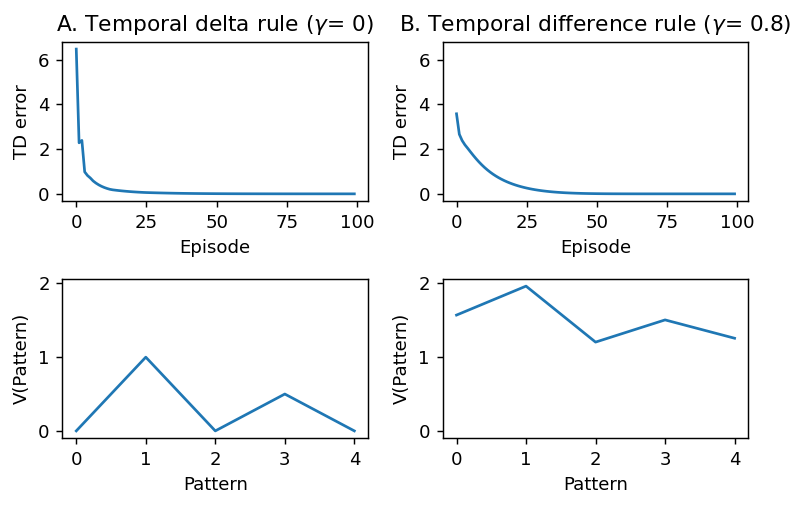

In [34]:
fig = plt.figure(dpi=130)

gamma = 0 
# reward = np.array([0, 0, 1, 0, 0])
reward = np.array([0, 1, 0, 0.5, 0])
lr = 0.2
n_episodes = 100
w, TDerror, patterns = fig9_16(reward, gamma, lr, n_episodes)

ax0 = plt.subplot(2,2,1)
plt.plot(TDerror);
plt.xlabel('Episode') # time step
plt.ylabel('TD error')
plt.title('A. Temporal delta rule ($\gamma$= 0)')

ax1 = plt.subplot(2,2,3);
V = w @ patterns
plt.plot(V)
plt.xlabel('Pattern') 
plt.ylabel('V(Pattern)');
plt.tight_layout()

gamma = 0.8
w, TDerror, patterns = fig9_16(reward, gamma, lr, n_episodes)

plt.subplot(2,2,2, sharey=ax0)
plt.plot(TDerror);
plt.xlabel('Episode') # time step
plt.ylabel('TD error')
plt.title('B. Temporal difference rule ($\gamma$= 0.8)')

plt.subplot(2,2,4, sharey=ax1);
V = w @ patterns
print(V)
plt.plot(V)
plt.xlabel('Pattern') 
plt.ylabel('V(Pattern)');
plt.tight_layout()

In A, where $\gamma=0, \ V$ of every pattern converges to it's reward, because future rewards play no role in determining the value of a stimulus. In B, future rewards have (discounted) value. The above is not the best first example to illustrate discounted future rewards, as the stimuli are seen theoretically infinite times in a loop, without a break at the end of each cycle, making the values which the simulation converges to not immediately obvious.\
Let's say that I'm currently pattern 1. In the example `reward = np.array([0, 1, 0, 0.5, 0])` pattern 1 gives me no reward, pattern 2 gives me a reward of 1 which is discounted by $\gamma$, pattern 3 again gives me no reward, pattern 4 gives me a reward of 0.5 which is discounted by $\gamma^3$, pattern 5 gives me no reward, again I see pattern 1 without a reward, and again I see pattern 2 which is now discounted by $\gamma^6$ and so forth. Overall, we can analytically calculate
$$
V_i = \sum_{j=1}^5 \sum_{t=0}^\infty r_j \gamma^{5t+ \text{distance between pattern i and pattern j}}\\
= \sum_{j=1}^5  r_j \gamma^{j-i \text{ mod 5}} \sum_{t=0}^\infty \gamma^{5t}
= \frac{1}{1-\gamma^5} \sum_{j=1}^5  r_j \gamma^{j-i \text{ mod 5}} 
$$
Let'c calculate this:

In [37]:
def circular_dist(i, j, n): 
    return (j-i) % n

def analytic_v(pattern): 
    dists = np.array([circular_dist(pattern, i, n_patterns) for i in range(n_patterns)])
    return sum(reward * gamma**dists) / (1-gamma**n_patterns)

In [38]:
n_patterns = patterns.shape[1]
print(np.array([analytic_v(pattern) for pattern in range(n_patterns)]))

[1.57068063 1.96335079 1.20418848 1.5052356  1.2565445 ]


This matches the $V$ values we got from the simulation.

## Figure 9.20

In [119]:
gamma = 0.8 
# reward = np.array([0, 1, 0, 0.5, 0])
reward = np.array([0, 0, 1, 0, 0])
n_patterns = len(reward)
pattern_len = 10
patterns = np.zeros([pattern_len, n_patterns]) 
patterns[0,2] = 1 # now only the third stimulus is presented and it is represented only by the first neuron
# patterns = np.random.rand(pattern_len, n_patterns)
print(patterns) 

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [120]:
w = np.zeros(pattern_len)
V_mem = 0 
previous_state = n_patterns-1
lr = 0.2
n_episodes = 100
TDerror = np.zeros(n_episodes)
delta = np.zeros([n_episodes, n_patterns])

In [121]:
for episode in range(n_episodes): 
    if episode == 50: # after half of the experiment start presenting the second stimulus as well, represented by the activity of the fourth neuron
        patterns[3,1] = 1
    for pattern in range(5):
        if (episode == 99) and (pattern == 2): break
        V = w @ patterns[:, pattern]
        delta[episode, pattern] = reward[previous_state] + gamma*V - V_mem
        w += lr * delta[episode, pattern] * patterns[:, previous_state].T
        TDerror[episode] += abs(delta[episode, pattern]);
        previous_state = pattern 
        V_mem = V

In [116]:
print(patterns)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


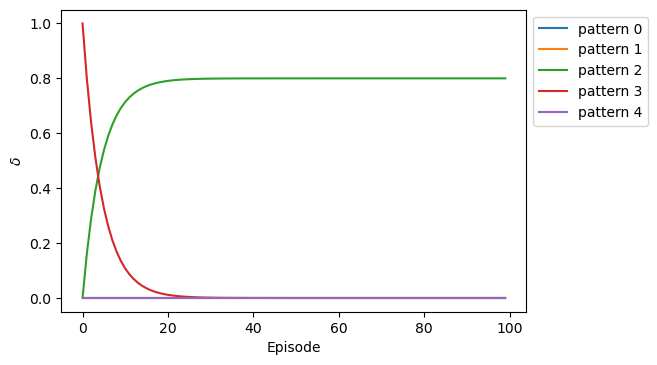

In [117]:
plt.figure(dpi=100)
plt.plot(rhat)
plt.xlabel('Episode')
plt.ylabel('$\delta$')
plt.legend([f'pattern {pattern}' for pattern in range(n_patterns)],
          bbox_to_anchor=(1,1));

First 50 episodes:\
A stimulus (activity of neuron 1) is presented at time 2 and a reward is given at time 3 in a loop. Initially, $\delta(\text{pattern } 2)=1$, because the reward comes as a surprise. Along the learning process, $V$ of pattern 2 converges to 1 and predicts fully the reward. Reminder: there is no discount for a reward that comes at the next time step. that is why $V$ of pattern 2 is 1 and not 0.8.\
On the other hand, $\delta(\text{pattern } 2)$ actually refers to the error in prediction of pattern 1. We predict $V$ after pattern 1 arrives, we wait for the next time step, and if there was no reward we just estimate the new $V$ and compare with a discount. Since $V(\text{pattern } 2) = 1$, it should be that $V(\text{pattern } 1) = 0.8$, but it is not, hence  $\delta(\text{pattern } 2)=0.8$. \
In other words, $\delta(\text{pattern } 2)=0.8$ because pattern 2, the first indicator of a reward, comes as a surprise, so $\delta(\text{pattern } 2) = \text{reward}(\text{pattern } 2) + \gamma V(\text{pattern } 2) - V(\text{pattern } 1) = 0 + 0.8\cdot1-0=0.8$.\
But why does pattern 2 come as a surprise? If "pattern" 1 was not all zeros (as in the second half of the experiment) it could have predicted pattern 2, but because it is basically nothing, the arrival of the stimulus which is pattern 2 is unpredictable. This is very realistic - Initially the reward surprises us, as it was not expected. After learning, the reward is of no surprise, since it is predicted by the stimulus. However, the stimulus still comes as a surprise. Before the stimulus we didn't expect anything, and now that the stimulus was given, we expect a reward at some point in the future - this is exactly the prediction error that centers the stimulus.
Last 50 episodes:\
Now at the time of pattern 1, some (different) stimulus (activity of neuron 3) is shown, so now it is actually a pattern and not only a time point. Following the explanation above, it's $V$ converges to 0.8, and the prediction error $\delta$ moves backwards in time to be 0.6, refering to pattern 0.

[0. 0. 1. 0. 0.]


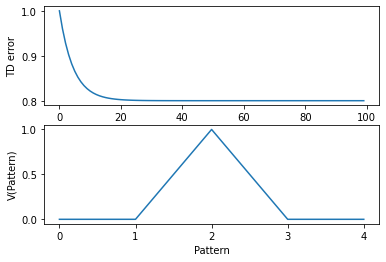

In [94]:
plt.subplot(2,1,1)
plt.plot(TDerror);
plt.xlabel('Episode')
plt.ylabel('TD error')
plt.subplot(2,1,2);
V = w @ patterns
print(V)
plt.plot(V)
plt.xlabel('Pattern') 
plt.ylabel('V(Pattern)')
plt.xticks(range(5));

Notice that although here future rewards are considered $(\gamma>0)$, a single time step in which all neurons are inactive basically "erases" the memory.